<a href="https://colab.research.google.com/github/garrettfarley9/AI-Final-Project/blob/main/AI_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns




##Phase 1 - Data Analysis

In [2]:
##Reading in data and calculating proportions of classes

# mdf = pd.read_csv('https://www.kaggle.com/datasets/ulrikthygepedersen/mushroom-attributes/download?datasetVersionNumber=1')
mdf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mushroom.csv')
counts = mdf.groupby(['class']).size()

mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises%3F                8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                8124 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

In [3]:
##Describe the dataset
mdf.describe().T


,count,unique,top,freq
cap-shape,8124,6,b'x',3656
cap-surface,8124,4,b'y',3244
cap-color,8124,10,b'n',2284
bruises%3F,8124,2,b'f',4748
odor,8124,9,b'n',3528
gill-attachment,8124,2,b'f',7914
gill-spacing,8124,2,b'c',6812
gill-size,8124,2,b'b',5612
gill-color,8124,12,b'b',1728
stalk-shape,8124,2,b't',4608


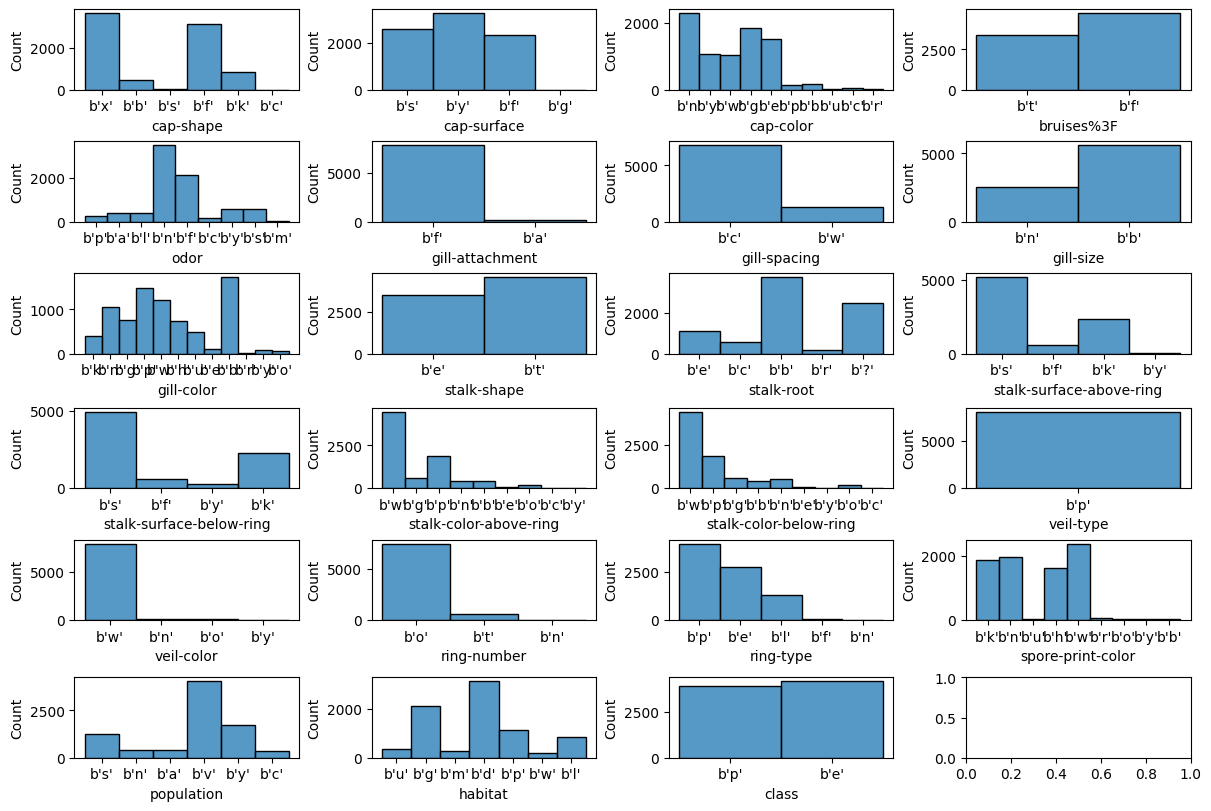

In [4]:
fig, ax = plt.subplots(nrows = 6, ncols = 4, figsize = (12,8), layout = 'constrained')
ax = ax.flatten()
for i, col in enumerate(mdf.columns):
    sns.histplot(mdf[col], ax=ax[i])
# plt.tight_layout()


In [5]:
##Label encoding
cols = mdf.columns
for c in cols:
  uni = mdf[c].unique()
  map = {}
  for x in range(len(uni)):
    map[uni[x]] = x
  mdf[c].replace(map, inplace= True)



In [6]:
mdf

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,1,1,1
2,1,0,2,0,2,0,0,1,1,0,...,0,0,0,0,0,0,1,1,2,1
3,0,1,2,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,3,1,3,0,1,1,0,1,...,0,0,0,0,0,1,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,4,0,0,1,3,1,0,1,10,0,...,6,7,0,2,0,0,8,5,6,1
8120,0,0,0,1,3,1,0,1,10,0,...,6,7,0,1,0,0,8,3,6,1
8121,3,0,0,1,3,1,0,1,1,0,...,6,7,0,2,0,0,8,5,6,1
8122,4,1,0,1,6,0,0,0,8,1,...,0,0,0,0,0,1,4,3,6,0


##Phase 2 - Overfitting

##Phase 3 - Model Selection and Validation

In [9]:
##Shuffle the data to mitigate overfitting
np.random.shuffle(mdf.values)

In [21]:
##Split into training and testing

index_20percent = int(0.2 * len(mdf.index))
print(index_20percent)
test = mdf[:index_20percent]
train = mdf[index_20percent:]

XVALID = test.drop(columns = 'class')
YVALID = pd.DataFrame(test['class'])
XTRAIN = train.drop(columns = 'class', axis = 1)
YTRAIN = pd.DataFrame(train['class'])
shapes = [XTRAIN, YTRAIN, XVALID, YVALID]
for i in shapes:
  print(i.shape)

1624
(6500, 22)
(6500, 1)
(1624, 22)
(1624, 1)


In [24]:
##Create simple logistic regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(2, input_dim = 22, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 46        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [25]:
##Log callbacks for model checkpoints
from keras.callbacks import EarlyStopping, ModelCheckpoint
callback_a = ModelCheckpoint(filepath = 'best_model', monitor = 'val_loss', save_best_only = True, save_weights_only = True)
callback_b = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20, verbose = 1)


In [38]:
##Fit the model and output epoch information
history = model.fit(XTRAIN, YTRAIN, validation_data = (XVALID, YVALID), epochs = 100, batch_size = 10, callbacks = [callback_a,callback_b], verbose = 0)

Epoch 61: early stopping


In [39]:
print(history.params)

{'verbose': 0, 'epochs': 100, 'steps': 650}


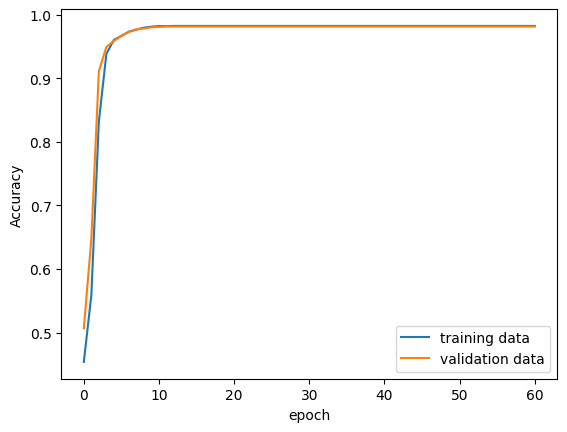

In [40]:
##Plot the accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc = 'lower right')
plt.show()

In [34]:
model.load_weights('best_model')

In [35]:
#Evaluate the model with training data
scores = model.evaluate(XTRAIN, YTRAIN)
print(model.metrics_names)
print(scores)
print(model.metrics_names[1], scores[1]*100)

204/204 [==============================] - 0s 2ms/step - loss: 0.0139 - accuracy: 0.9975
['loss', 'accuracy']
[0.013934679329395294, 0.9975384473800659]
accuracy 99.75384473800659


In [ ]:
##Evaluate the model with test data
scores = model.evaluate(XVALID, YVALID)
print(model.metrics_names[1], scores[1]*100)

In [72]:
print(XVALID[0:5])
print(YVALID[0:5])

  cap-shape cap-surface cap-color bruises%3F  odor gill-attachment  \
0      b'x'        b's'      b'w'       b't'  b'f'            b'f'   
1      b'x'        b's'      b'g'       b'f'  b'c'            b'f'   
2      b'x'        b'y'      b'n'       b't'  b'n'            b'f'   
3      b'f'        b'y'      b'g'       b't'  b'n'            b'f'   
4      b's'        b'f'      b'g'       b'f'  b'n'            b'f'   

  gill-spacing gill-size gill-color stalk-shape  ... stalk-surface-below-ring  \
0         b'c'      b'b'       b'h'        b't'  ...                     b's'   
1         b'w'      b'n'       b'n'        b'e'  ...                     b's'   
2         b'c'      b'b'       b'u'        b't'  ...                     b's'   
3         b'c'      b'b'       b'n'        b't'  ...                     b's'   
4         b'c'      b'n'       b'n'        b'e'  ...                     b's'   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                   

In [ ]:
##Show plot for what the prediction values actually are
prediction = model.predict(XVALID)
print(prediction[0:10])
print(prediction[0:10].round())

plt.plot(YVALID, prediction, '.', alpha = 0.3)
plt.xlabel('Correct labels')
plt.ylabel('Predicted confidence scores')
plt.show()

In [ ]:
##Doesn't work. Use for logistic regression
def my_prediction_function(model, data):
  w = [None]*numOfFeatures
  for i in range(numOfFeatures):
     w[i] = model.layers[numOfLayers-1].get_weights()[0][i]
  bias = model.layers[numOfLayers-1].get_weights()[1] 
  z = 0
  for i in range(numOfFeatures):
    z = z + features[numOfLayers-2][:,i]*w[i]
  z = z + bias
  result = 1/(1+np.exp(-z))
  return result 

In [ ]:
##Iterate through different complexities of neural network models
def model_mash(first = [], hiddens = [[]]):
  models = []
  first = first
  hiddens = hiddens
  for k in range(len(first)):
    inst = Sequential()
    inst.add(Dense(first[k], input_dim = 22, activation = 'relu'))
    for l in range(len(hiddens[k])):
      inst.add(Dense(hiddens[k][l], activation = 'relu'))
    inst.add(Dense(1, activation = 'sigmoid'))
    print(inst.summary())
    inst.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    history = inst.fit(XTRAIN, YTRAIN, validation_data = (XVALID, YVALID), epochs = 10, batch_size = 10, callbacks = [callback_a,callback_b])
    scores_train = inst.evaluate(XTRAIN, YTRAIN)
    print(inst.metrics_names)
    print(inst.metrics_names[1], scores_train[1]*100)
    scores_test = inst.evaluate(XVALID, YVALID)
    print(inst.metrics_names[1], scores_test[1]*100)
    models.append([inst, inst.metrics_names[1], scores_train[1]*100, scores_test[1]*100])


In [ ]:
##Call the function
model_mash(first = [64,32,16,8,4,2], hiddens = [[32,16,8],[16,8],[8],[],[],[]])

In [63]:
##Dummy classifier
counts['p'] = [counts[0] / (counts[0]+counts[1]) , counts[1] / (counts[0]+counts[1])]
print(counts)
baseline = counts['p'][0]**2 + counts['p'][1]**2
print(baseline)

class
b'e'                                        4208
b'p'                                        3916
p       [0.517971442639094, 0.48202855736090594]
dtype: object
0.5006459455010605


In [ ]:
##Show the datatable for the accuracy of each model against the others
print('-Model-', '-Training Acc-', '-Test Acc-')
for x in range(len(models)):
  print(first[x], hiddens[x], '1', ':' , models[x][2], models[x][3])


##Phase 4 - Feature Importance

In [ ]:
fYTRAIN = YTRAIN
fYTEST = YVALID
bars_name = []
bars_val = []

for f in range(len(cols)-1):
  fXTRAIN = XTRAIN[cols[f]]
  fXTEST = XVALID[cols[f]]
  feat = Sequential()
  feat.add(Dense(2, input_dim = 1, activation = 'relu'))
  feat.add(Dense(1, activation = 'sigmoid'))
  feat.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  history_feat = feat.fit(fXTRAIN, fYTRAIN, validation_data = (fXTEST,fYTEST), epochs = 5, batch_size = 10, callbacks = [callback_a,callback_b])
  fscore = feat.evaluate(fXTEST, fYTEST)
  bars_name.append(cols[f])
  bars_val.append(fscore[1]*100)




Epoch 1/5
650/650 [==============================] - 3s 3ms/step - loss: 0.8019 - accuracy: 0.4657 - val_loss: 0.7182 - val_accuracy: 0.4409
Epoch 2/5
650/650 [==============================] - 1s 2ms/step - loss: 0.7064 - accuracy: 0.4335 - val_loss: 0.6973 - val_accuracy: 0.4532
Epoch 3/5
650/650 [==============================] - 1s 2ms/step - loss: 0.6944 - accuracy: 0.4797 - val_loss: 0.6933 - val_accuracy: 0.4969
Epoch 4/5
650/650 [==============================] - 1s 2ms/step - loss: 0.6924 - accuracy: 0.5232 - val_loss: 0.6941 - val_accuracy: 0.4969
Epoch 5/5
51/51 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.4969
Epoch 1/5
650/650 [==============================] - 2s 2ms/step - loss: 0.6880 - accuracy: 0.5520 - val_loss: 0.6816 - val_accuracy: 0.5468
Epoch 2/5
650/650 [==============================] - 1s 2ms/step - loss: 0.6744 - accuracy: 0.5558 - val_loss: 0.6806 - val_accuracy: 0.5468
Epoch 3/5
650/650 [==============================] - 2s 2

Exception ignored in: <function _xla_gc_callback at 0x7fde621c52d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


650/650 [==============================] - 62s 94ms/step - loss: 0.6652 - accuracy: 0.7448 - val_loss: 0.6388 - val_accuracy: 0.7383
Epoch 2/5
650/650 [==============================] - 1s 2ms/step - loss: 0.6203 - accuracy: 0.7454 - val_loss: 0.6060 - val_accuracy: 0.7383
Epoch 3/5
650/650 [==============================] - 1s 2ms/step - loss: 0.5929 - accuracy: 0.7454 - val_loss: 0.5892 - val_accuracy: 0.7383
Epoch 4/5
650/650 [==============================] - 2s 3ms/step - loss: 0.5775 - accuracy: 0.7454 - val_loss: 0.5801 - val_accuracy: 0.7383
Epoch 5/5
650/650 [==============================] - 2s 3ms/step - loss: 0.5686 - accuracy: 0.7454 - val_loss: 0.5752 - val_accuracy: 0.7383


In [31]:
# sns.histplot(data = bars)
bars

[['accuracy', 55.91133236885071], ['accuracy', 54.6798050403595]]